In [73]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import os
from saferl import *
from helpers import *
from config import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Experiment settings

### Choosing a setting

In [411]:
#R = small_setting()
R = medium_setting()
#R = big_setting()
#R = batch_size_setting()

In [412]:
# name of the setting, common parameters, parameter groups, all parameters
setting_name, common, param_groups = R
parameters = [x for group in param_groups.values() for x in group]

In [413]:
# group -> what changes
varying = {group: varying_for_agent(param_groups[group]) for group in param_groups.keys()}

print(varying)

{'cpo': ['delta'], 'random': [], 'sppo': ['lr_policy', 'steps', 'lr_failsafe', 'lr_value']}


### Processing data

In [382]:
def process_dict(d, do_plot, name):
    #print(d)
    # all keys
    keys = d[0][0].keys()
    results = []
    for run in d:
        run_data = arr_of_dicts_to_dict_of_arrays(run)
        #plot_RC(run_data, common['constraint'], '-', clear = False)
        mean_cost = np.array([x[0] for x in run_data['Cost']])
        mean_rew = np.array([x[0] for x in run_data['Reward']])
        #if np.mean(mean_cost > common['constraint'] + 10) > 0.01:
#            print('Violated too many times')
#            results.append(-1)
#        else:
        #results.append(np.max(mean_rew[np.where(mean_cost <= common['constraint'])]))
        results.append([mean_rew, mean_cost])
        #print(run_data['Cost'])
    return results

In [383]:
def process_file(f, name, do_plot = False):
    """ Process one file """
    if not os.path.isfile(f):
        print('!!! File  missing ' + f)
        return
    
    content = open(f, 'r').read()
    if content.startswith('Nothing['):
        print('!!! File  is empty')
        return
    
    try:
        d = eval(content)
        return process_dict(d, do_plot, name)
    except Exception as e:
        print('!!! File cannot be processed ' + str(e))
        return None
    #return d

In [384]:
def param_to_result(param, parameters, params_to_processed):
    """ Parameter setting to results summary """
    idx = parameters.index(param)
    return params_to_processed[idx]

In [398]:
# parameter id -> processed file
params_to_processed = []
missing = []
done = 0
for param in parameters:
    fs = process_file(get_file(**param), 'loss_decay_' + setting_name + '_' + shorten_dict(param, filename = True), True)
    print(param)
    #print(dict_to_stat(fs))
    print("-----")
    if fs is not None:
        done += 1
    else:
        missing.append(param)
    params_to_processed.append(fs)
    #break
print('Done: %d/%d' % (done, len(parameters)))

{'agent': 'cpo', 'delta': 0.1, 'epochs': 5000, 'constraint': 100.0, 'episodes': 5, 'repetitions': 5}
-----
{'agent': 'cpo', 'delta': 0.001, 'epochs': 5000, 'constraint': 100.0, 'episodes': 5, 'repetitions': 5}
-----
{'agent': 'random', 'epochs': 5000, 'constraint': 100.0, 'episodes': 5, 'repetitions': 5}
-----
{'agent': 'sppo', 'epsilon': 0.1, 'steps': 1, 'lr_policy': 0.1, 'lr_value': 0.1, 'lr_failsafe': 0.1, 'epochs': 5000, 'constraint': 100.0, 'episodes': 5, 'repetitions': 5}
-----
{'agent': 'sppo', 'epsilon': 0.1, 'steps': 1, 'lr_policy': 0.1, 'lr_value': 0.1, 'lr_failsafe': 0.001, 'epochs': 5000, 'constraint': 100.0, 'episodes': 5, 'repetitions': 5}
-----
{'agent': 'sppo', 'epsilon': 0.1, 'steps': 1, 'lr_policy': 0.001, 'lr_value': 0.1, 'lr_failsafe': 0.1, 'epochs': 5000, 'constraint': 100.0, 'episodes': 5, 'repetitions': 5}
-----
{'agent': 'sppo', 'epsilon': 0.1, 'steps': 1, 'lr_policy': 0.001, 'lr_value': 0.1, 'lr_failsafe': 0.001, 'epochs': 5000, 'constraint': 100.0, 'episodes':

In [414]:
# cost threshold
thresh = common['constraint']

In [415]:
def get_metrics_run(run):
    """ Process one set of parameters """

    rew, cost = run

    constr_satisf = cost <= thresh

    metrics = {}
    metrics['constraint'] = np.mean(constr_satisf)
    metrics['max_safe_reward'] = np.max(rew[constr_satisf])
    metrics['all_reward'] = np.max(rew)

    return metrics

In [416]:
def get_metrics_param(param):
    """ Metrics for a dict of params """
    idx = parameters.index(param)

    proc_data = params_to_processed[idx]

    result = []
    for run in proc_data:
        result.append(get_metrics_run(run))
    return arr_of_dicts_to_dict_of_arrays(result)

In [417]:
def process_agent(agent, params):
    """ Calculate everything for an agent """
    res = arr_of_dicts_to_dict_of_arrays([get_metrics_param(agent) for agent in params])
    for key in res.keys():
        labels = [shorten_dict(dict_select(p, varying_for_agent(params))) for p in params]
        plt.figure()
        plt.title(key)
        plt.boxplot(res[key], labels = labels)
        plt.xticks(rotation=90)
        plt.show()
    agent_data[agent] = res

In [418]:
agent = 'sppo'

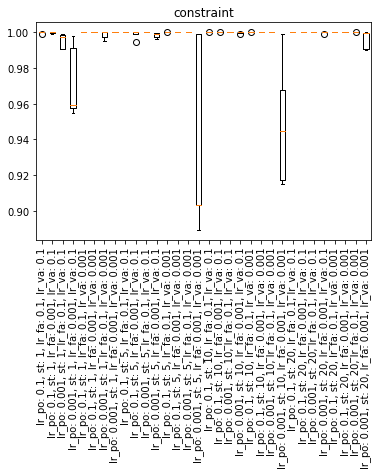

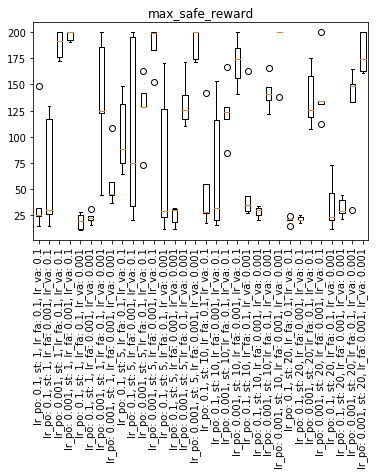

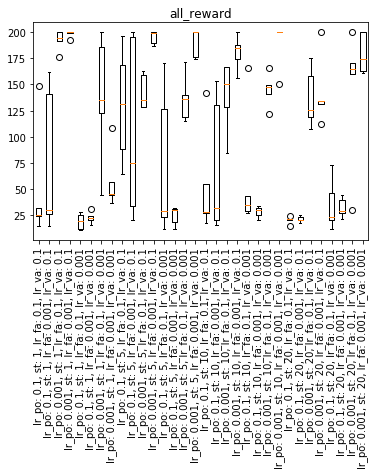

In [419]:
agent_data = {agent: [] for agent in param_groups.keys()}
process_agent(agent, param_groups[agent])

In [420]:
agent = 'sppo'
rew_thr = 175
agent_good_enough = np.where(np.mean(agent_data[agent]['max_safe_reward'], axis = 1) >= rew_thr)[0]
params_selected = [param_groups[agent][i] for i in range(len(param_groups[agent])) if i in agent_good_enough]

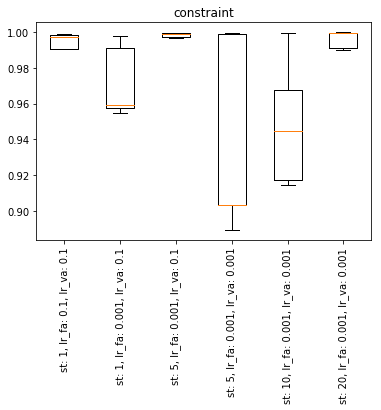

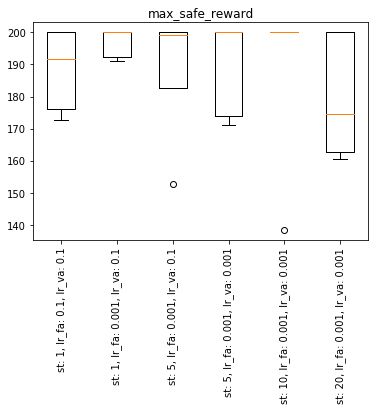

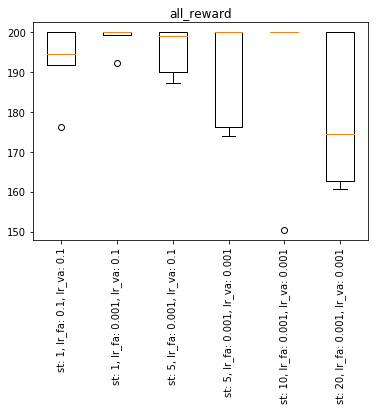

In [421]:
process_agent(agent, params_selected)

In [ ]:
# Have 6 options 1-6. Choosing either 1, 3 or 6. Choosing 3 as reward is highest
sppo_best_param = params_selected[2]

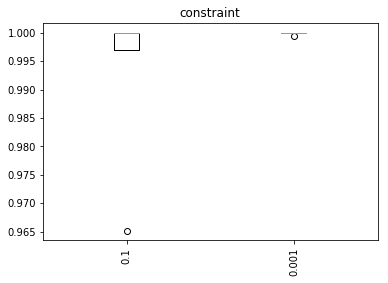

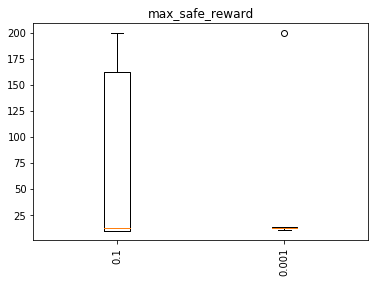

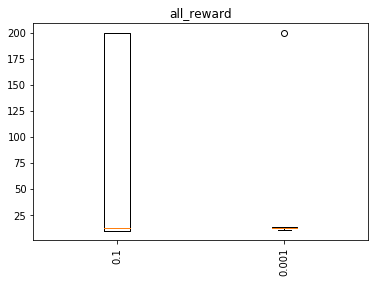

In [426]:
process_agent('cpo', param_groups['cpo'])

In [ ]:
# For cpo, 0th params are the best so far

In [427]:
best_params = {'sppo': sppo_best_param,
              'random': param_groups['random'][0],
              'cpo': param_groups['cpo'][0]}

sppo {'lr_policy': 0.001, 'steps': 5, 'lr_failsafe': 0.001, 'lr_value': 0.1}
(2, 5000)


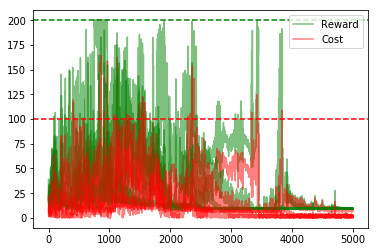

random {}
(2, 5000)


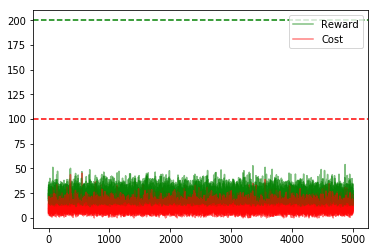

cpo {'delta': 0.1}
(2, 5000)


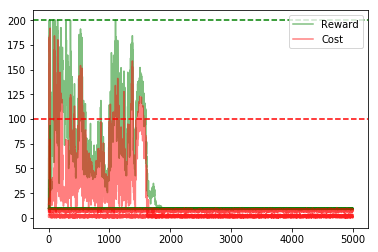

In [457]:
for agent, params in best_params.items():
    print(agent, dict_select(params, varying_for_agent(param_groups[agent])))
    idx = parameters.index(params)
    proc_data = params_to_processed[idx]
    mins = np.min(proc_data, axis = 0)
    maxes = np.max(proc_data, axis = 0)
    print(means.shape)
    #for i, run in enumerate(proc_data):
    
    for i, run in enumerate(proc_data):
        label = i == 0
        plt.plot(range(len(mins[0])), run[0], label = 'Reward' if label else None, color = 'green', alpha = 0.5)
        plt.plot(range(len(mins[0])), run[1], label = 'Cost' if label else None, color = 'red', alpha = 0.5)
    #plt.plot(means[1], label = 'Cost', color = 'red', alpha = 0.3)
    plt.axhline(y = 100, ls = '--', color = 'red')
    plt.axhline(y = 200, ls = '--', color = 'green')
    plt.savefig('output/figures/agent-%s-best.pdf' % agent)
    plt.legend()
    plt.show()